In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from datetime import datetime
from numpy.random import random

In [2]:
# Поиск ближашей точки
# по развертывающимуся квадрату (в пределах 30) и возвращение дистанции
def box(ox, oy, image):
    pix = image.load() 
    distance = 0
    try:
        for limit in range(1, 31):
            x = ox + limit
            y = oy + limit
            for ix in range(limit*2+1):
                x = x - 1
                if pix[x,y] == (0,0,0):
                    dnew = (x-ox)**2 + (y-oy)**2
                    if dnew < distance or distance == 0:
                        distance = dnew
            for iy in range(limit*2+1):
                y = y - 1
                if pix[x,y] == (0,0,0):
                    dnew = (x-ox)**2 + (y-oy)**2
                    if dnew < distance or distance == 0:
                        distance = dnew
            for jx in range(limit*2+1):
                x = x + 1
                if pix[x,y] == (0,0,0):
                    dnew = (x-ox)**2 + (y-oy)**2
                    if dnew < distance or distance == 0:
                        distance = dnew
            for jy in range(limit*2+1):
                y = y + 1
                if pix[x,y] == (0,0,0):
                    dnew = (x-ox)**2 + (y-oy)**2
                    if dnew < distance or distance == 0:
                        distance = dnew
            if distance > 0:
                return(distance)
    except IndexError:
        pass
    return(distance)

In [3]:
# Генератор точек с вероятностью 0.002 с параметрос n
def generatorJPG(image, n):
    for x in range(width//2):
        for y in range(height//2):
                if random() < n*0.002:
                    draw.point((x,y), 0)            
    return(image)

In [4]:
def generatorExtend(image, partition, n):
    return

In [5]:
#  Разбиение плоскости на n=1 область лучами
#  Сбор данных с областей: 
# количество точек, минмальная\максимальная\средняя дистанции
def sun(n):
    partition = [0]*(4*(n+1))
    for x in range(width//2):
        for y in range(height//2):
            if pix[x,y] == (0,0,0): #проверка точки
                # сбор данных
                distance = box(x,y,image)#дистанция
                # классификация на области
                for c in range(n+1):
                    if (y+1)/(x+1) > math.tan((c*math.pi)/(2*(n+1))):
                        partition[4*c] = partition[4*c] + 1
                        # минимум
                        if partition[4*c+1] > distance or partition[4*c+1] == 0:
                            partition[4*c+1] = distance
                        # максимум
                        if partition[4*c+2] < distance:
                            partition[4*c+2] = distance
                        partition[4*c+3] = partition[4*c+3] + distance # сложение дистанций
    for c in range(n):
        partition[4*c] = partition[4*c] - partition[4*(c+1)]
    return(partition)


 [21, 2, 712, 12498, 40, 2, 712, 10410, 28, 4, 425, 4263]
C:\Users\B150M-C\JupyterProject\Machine learning\images\D31012021 02 05.jpg


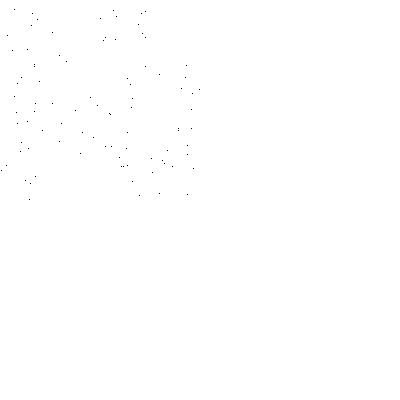

In [6]:
image = Image.new(mode='RGB', size=(400,400),color=(255,255,255))
draw = ImageDraw.Draw(image)
width = image.size[0]
height = image.size[1]
pix = image.load()

image = generatorJPG(image, 1)
print('\n', sun(2))
time = datetime.now().strftime("%d%m%Y %H %M") + '.jpg'
directory = r'C:\Users\B150M-C\JupyterProject\Machine learning\images\D' + time 
print(directory)
image.save(directory)

del draw

image